# Introduction

You are the new mayor of a mid-sized city in the southern United States. You campaigned on a promise to reduce crime and now it's time to make good. 

You have two promising programs aimed at those at highest risk of re-arrest. 

For the final project we are going to decide between these two programs.  

```
1) A custom notification program
Under this program, police officers visit the homes of high-risk individuals and notify them of their status. They additionally warn these individuals that the police is keeping a closer eye on them. The custom notification program is relatively cheap to run, so it can serve 1,000 individuals, but it will likely lead to more people being arrested.
```

```
2) A summer jobs program
Under this program, social workers visit the homes of high-risk individuals and offer them a slot in a summer jobs program which has been shown to be effective in increasing employment and reducing criminal justice involvement. The summer jobs program is expensive to run, so it can serve 500 individuals, but many of those served will likely not have been re-arrested even without the program. 
```

In [2]:
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# YOU ARE FREE TO USE WHATEVER ALGORITHM YOU WANT BUT I HAVE IMPORTED SOME FOR YOU BELOW
import seaborn as sns
from sklearn.metrics import roc_auc_score as auc
from sklearn.ensemble import RandomForestClassifier as RF_clf
from sklearn.linear_model import LogisticRegression as LR_clf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Part 1 

## Load data
We will work with the following dataset:
 - **Xy**: Has the following columns 
   - `ArresteeID`: Unique ID for an arrestee
   - `outcome__rearrested_in_2019` : The outcome to predict
   - `charges__NIBRS_Group_X__YYYY` : This is a count of the number of charges of type X in the year YYYY. 
     - X is either A, B or C
     - YYYY is either 2016, 2017, or 2018
   - `arrests__race__XXXX` : Where XXXX is either Black, Hispanic, Other, or White
 - **arrests** : 
   - `IncidentNum`: Unique ID for an incident
   - `ArrestYr`: Year of arrest
   - `ArrestNumber`: Unique ID for an arrest
   - `ArWeapon` : Any weapons identified by the arresting officer
   - `arr_age`: Current age of arrestee
   - `arr_gender`: Gender of arrestee at incident
   - `ArresteeID`: Unique ID for an arrestee
 - **charges** : 
   - `ArrestNumber`: Unique ID for an arrest
   - `ArChgNumID`: Unique ID for an arrest charge
   - `Severity`: Misdemeanor or Felony
   - `NIBRS_Group`: Is charge of type A (most severe), B (less severe), or C (traffic incident)
   - `NIBRS_Crime_Category`: The category of the charge
 - **incidents** : 
   - `IncidentNum`: Unique ID for an incident
   - `incident_type`: Free text field describing the incident
   - `vic_type`: Whether the victim was a person, business, law enforcement, or the government 
   - `mo`: Free text field briefly describing the incident
   - `weapon_used`: Free text field listing the type of weapon if any
   - `gang_related`: Indication if the incident was gang-related
   
 
Both datasets have the following columns:
  - **`outcome__rearrested_in_2019`**: The actual outcome
  - **`race__Black`** : A binary-valued column with 1=Black 0=Not Black
  - **`race__White`** : A binary-valued column with 1=White 0=Not White
  - **`race__Hispanic`** : A binary-valued column with 1=Hispanic or Latino 0=Not Hispanic or Latino
  - **`gender__M`** : A binary-valued column with 1=Male gender and 0=Non-Male
  - **`network__any_1st_deg_nabe__all`** : A binary-valued column that tells us whether the person has ever been arrested with someone else
  - **`prediction` : The models predicted probability of the outcome

## Prediction Setup
We will be predicting whether someone arrested in 2018 will be re-arrested in 2019.



In [3]:
Xy = pd.read_csv('./Xy_final_project.csv')
arrests = pd.read_csv('./arrests_final_project.csv')
charges = pd.read_csv('./charges_final_project.csv')
incidents = pd.read_csv('./incidents_final_project.csv')

Xy.head()
arrests.head()
charges.head()
incidents.head()

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0
3,2856607,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0
4,2921408,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0


,IncidentNum,ArrestYr,ArrestNumber,ArWeapon,arr_age,arr_gender,ArresteeID
0,104552-2020,2020,20-018820,Unarmed,51.0,Male,102468259
1,104552-2020,2020,20-018820,Unarmed,51.0,Male,8607720
2,104552-2020,2020,20-018820,Unarmed,51.0,Male,102253069
3,104552-2020,2020,20-018820,Unarmed,51.0,Male,102366171
4,104552-2020,2020,20-018820,Unarmed,51.0,Male,102315487


,ArrestNumber,ArChgNumID,Severity,NIBRS_Group,NIBRS_Crime_Category
0,14-036903,14-036903-01,F,A,DRUG/ NARCOTIC VIOLATIONS
1,16-012390,16-012390-01,M,B,DRIVING UNDER THE INFLUENCE
2,15-048343,15-048343-01,M,B,PUBLIC INTOXICATION
3,16-015720,16-015720-03,M,C,TRAFFIC VIOLATION - NON HAZARDOUS
4,15-040648,15-040648-01,M,B,DRIVING UNDER THE INFLUENCE


,IncidentNum,incident_type,vic_type,mo,weapon_used,gang_related
0,207055-2018,ASSAULT -PUB SERV (PEACE OFFICER/JUDGE),Law Enforcement Offi,A/P BIT OFFICER ON THE LEFT HAND CAUSING INJURY,Personal Weapons (Hands-Feet ETC),UNK
1,243817-2018,TRAF VIO -OPERATE MOTOR VEH W/O FIN RESP,Government,A/P WAS UNABLE TO PROVIDE PROOF OF INSURANCE,NaN,NaN
2,245226-2018,OTHER OFFENSE - MISDEMEANOR,Government,AP WAS IN POSSESSION OF DRUG PARAPHERNALIA,NaN,NaN
3,133767-2019,POSS MARIJUANA <2OZ,Government,A/P WAS IN POSSESSION OF MARIJUANA.,NaN,NaN
4,273676-2018,POSS CONT SUB PEN GRP 1 <1G,Government,AP WAS IN POSSESSION OF COCAINE,NaN,NaN


## Learning about our outcome (2 total points)
1) Using `Xy`, what is the share of 2018 arrestees were arrested in 2019. Would you say this is a high or low base rate? (1 point)

2) Repeat 1) but now by the three race categories. Which race group has the highest base rate? (1 point)



In [4]:
# use value_counts normalize function to see share of arrestees rearreseted in 2019
Xy.outcome__rearrested_in_2019.value_counts(normalize=True)

0    0.927714
1    0.072286
Name: outcome__rearrested_in_2019, dtype: float64

#### I would consider this a fairly low base rate since I know the national recidivism rate is fairly high. 

In [5]:
# Using loc to filter and value_counts normalize
# Black group
Xy.loc[Xy.arrests__race__Black == 1].outcome__rearrested_in_2019.value_counts(normalize=True)

# Hispanic Group
Xy.loc[Xy.arrests__race__Hispanic == 1].outcome__rearrested_in_2019.value_counts(normalize=True)

# White Group
Xy.loc[Xy.arrests__race__White == 1].outcome__rearrested_in_2019.value_counts(normalize=True)

# Other Group
Xy.loc[Xy.arrests__race__Other == 1].outcome__rearrested_in_2019.value_counts(normalize=True)

0    0.915995
1    0.084005
Name: outcome__rearrested_in_2019, dtype: float64

0    0.940905
1    0.059095
Name: outcome__rearrested_in_2019, dtype: float64

0    0.93343
1    0.06657
Name: outcome__rearrested_in_2019, dtype: float64

0    0.932367
1    0.067633
Name: outcome__rearrested_in_2019, dtype: float64

#### The highest rearrest base rate belongs to the black arrestee race group

## Feature Generation (5.5 total points, 2 extra credit points)
1) Create a feature (or features) using the `incidents` data frame and merge these features into Xy. (1.5 points)
 
  

2) Create one or more features of your choice using any of the data frames you'd like (2 points, 2 additional extra credit points for creativity of your feature). Merge these features in with Xy as well.
 
 

3) Use sns.regplot to create two separate plots that show the relationship between the features you created and the outcome. (If you created more than two features, just pick two and plot) Based on these plots, which feature is more predictive of the outcome? (2 point)

 
 
 

In [6]:
##--------------------------------------------------------------------------------
# Creating featues using the incidents data frame
# Looking at the mo for key words to extract features from
incidents.mo.value_counts().head(50)

PUBLIC INTOXICATION                                                  977
AP WAS INTOXICATED IN PUBLIC                                         300
AP WAS INTOXICATED                                                   217
A/P WAS DRIVING WHILE INTOXICATED.                                   202
AP WAS IN POSSESSION OF MARIJUANA                                    172
DWI                                                                  148
THE ARRESTED PERSON WAS ARRESTED FOR DRIVING WHILE INTOXICATED.      144
AP WAS INTOXICATED IN A PUBLIC PLACE                                 122
AP WAS ARRESTED FOR PUBLIC INTOXICATION                              108
A/P WAS INTOXICATED IN PUBLIC                                        105
PUBLIC INTOX                                                          90
AP WAS ARRESTED FOR DWI.                                              81
CRIMINAL TRESPASS                                                     75
A/P WAS PLACED UNDER ARREST FOR DWI.               

In [7]:
# Most incidents appear to be alcohol related
incidents.mo.str.contains('INTOX|DWI|ALCOHOL|PI').value_counts()

False    9600
True     7447
Name: mo, dtype: int64

In [8]:
# Good amount of drug related incidents as well
incidents.mo.str.contains('POSS|DRUG|NARC|PARA').value_counts()

False    13642
True      3405
Name: mo, dtype: int64

In [9]:
# Mapping incidents to new columns related to alcohol and drugs based on key words
incidents['alcohol_related'] = incidents.mo.str.contains('INTOX|DWI|ALCOHOL|PI').map({True : 1, 
                                                                                False : 0})
incidents['drug_related'] = incidents.mo.str.contains('POSS|DRUG|NARC|PARA').map({True : 1, 
                                                                                False : 0})

In [10]:
incidents['alcohol_related'].value_counts()

0.0    9600
1.0    7447
Name: alcohol_related, dtype: int64

In [11]:
incidents['drug_related'].value_counts()

0.0    13642
1.0     3405
Name: drug_related, dtype: int64

In [12]:
# creating df merging incidents with the new columns with the arrests df (to relate to ArresteeID)
arrests_incidents = pd.merge(arrests,incidents, on="IncidentNum", how="left")

In [13]:
arrests_incidents.head()

,IncidentNum,ArrestYr,ArrestNumber,ArWeapon,arr_age,arr_gender,ArresteeID,incident_type,vic_type,mo,weapon_used,gang_related,alcohol_related,drug_related
0,104552-2020,2020,20-018820,Unarmed,51.0,Male,102468259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104552-2020,2020,20-018820,Unarmed,51.0,Male,8607720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104552-2020,2020,20-018820,Unarmed,51.0,Male,102253069,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104552-2020,2020,20-018820,Unarmed,51.0,Male,102366171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104552-2020,2020,20-018820,Unarmed,51.0,Male,102315487,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Creating two new df with columns grouped on ArresteeID 
alcohol_related = arrests_incidents.groupby('ArresteeID')['alcohol_related'].sum().reset_index(name='incidents__alcohol_related__all')

drug_related = arrests_incidents.groupby('ArresteeID')['drug_related'].sum().reset_index(name='incidents__drug_related__all')

In [15]:
# Merging the alcohol related df to Xy
Xy = pd.merge(Xy, alcohol_related, on="ArresteeID", how='left')
Xy.head()

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White,incidents__alcohol_related__all
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1.0
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0.0
3,2856607,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0,3.0
4,2921408,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12238,102720805,0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,8.0
12239,102724697,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,2.0
12240,102730586,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,2.0
12241,102758342,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0


In [16]:
# Merging the drug related df to Xy
Xy = pd.merge(Xy, drug_related, on="ArresteeID", how='left')
Xy.head()

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,charges__NIBRS_Group_C__2018,arrests__race__Black,arrests__race__Hispanic,arrests__race__Other,arrests__race__White,incidents__alcohol_related__all,incidents__drug_related__all
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,1.0,0.0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1.0,0.0
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1,0,0,0,0.0,1.0
3,2856607,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0,1,0,0,3.0,0.0
4,2921408,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0,0,1.0,0.0


In [ ]:
##------------------------------------------------------------------------
## Feature Building using remaining df
## Creating a feature to indicate age upon first arrest

In [18]:
# Merging arrests and charges df for ease of feature building
arrest_charges = pd.merge(arrests, charges, on="ArrestNumber", how='left')
arrest_charges.head()

,IncidentNum,ArrestYr,ArrestNumber,ArWeapon,arr_age,arr_gender,ArresteeID,ArChgNumID,Severity,NIBRS_Group,NIBRS_Crime_Category
0,104552-2020,2020,20-018820,Unarmed,51.0,Male,102468259,20-018820-01,M,B,TRESPASS OF REAL PROPERTY
1,104552-2020,2020,20-018820,Unarmed,51.0,Male,8607720,20-018820-01,M,B,TRESPASS OF REAL PROPERTY
2,104552-2020,2020,20-018820,Unarmed,51.0,Male,102253069,20-018820-01,M,B,TRESPASS OF REAL PROPERTY
3,104552-2020,2020,20-018820,Unarmed,51.0,Male,102366171,20-018820-01,M,B,TRESPASS OF REAL PROPERTY
4,104552-2020,2020,20-018820,Unarmed,51.0,Male,102315487,20-018820-01,M,B,TRESPASS OF REAL PROPERTY


(array([1.8976e+04, 2.4040e+04, 1.6741e+04, 1.1934e+04, 8.1130e+03,
        1.6860e+03, 1.7200e+02, 7.2000e+01, 4.0000e+00]),
 array([18., 27., 36., 45., 54., 63., 72., 81., 90., 99.]),
 <BarContainer object of 9 artists>)

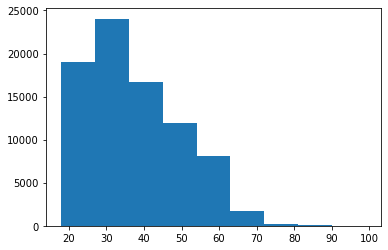

In [44]:
# Looking at different bin sizes. 9 seems like the best distribution and nice round numbers

import matplotlib.pyplot as plt

plt.hist(arrests.arr_age, bins=9)
plt.show()

In [19]:
# using agg function to separate min (did max incase I wanted to make another feature)

arrest_charges_nums = arrest_charges.groupby(['ArresteeID'])['arr_age'].agg([('min', np.min), ('max', np.max)])

In [20]:
# Creating a function to make bins for the ages (used bins from above)
def make_bins_age(df):
   label_names = ["18-26", "27-35","36-44", "45-54","54-62","63-71","72-80","81-89","90-99"]
   cut_points = [18., 27., 36., 45., 54., 63., 72., 81., 90., 99.]
   df["first_arrested_age_group"] = pd.cut(df["min"], cut_points, labels=label_names)
   return df

In [21]:
# run the function to separate the min column into the bins
first_age_arrest = make_bins_age(arrest_charges_nums)
first_age_arrest.first_arrested_age_group.value_counts()

27-35    16893
18-26    16800
36-44    10767
45-54     6868
54-62     4419
63-71      910
72-80      128
81-89       43
90-99        3
Name: first_arrested_age_group, dtype: int64

In [22]:
# the values match up
first_age_arrest.shape
arrest_charges.ArresteeID.nunique()

(57816, 3)

57816

In [23]:
# Merging this new column back into the arrest_charges df
arrest_charges = pd.merge(arrest_charges, first_age_arrest, on="ArresteeID", how="left")
arrest_charges.head()

,IncidentNum,ArrestYr,ArrestNumber,ArWeapon,arr_age,arr_gender,ArresteeID,ArChgNumID,Severity,NIBRS_Group,NIBRS_Crime_Category,min,max,first_arrested_age_group
0,104552-2020,2020,20-018820,Unarmed,51.0,Male,102468259,20-018820-01,M,B,TRESPASS OF REAL PROPERTY,51.0,51.0,45-54
1,104552-2020,2020,20-018820,Unarmed,51.0,Male,8607720,20-018820-01,M,B,TRESPASS OF REAL PROPERTY,51.0,51.0,45-54
2,104552-2020,2020,20-018820,Unarmed,51.0,Male,102253069,20-018820-01,M,B,TRESPASS OF REAL PROPERTY,51.0,51.0,45-54
3,104552-2020,2020,20-018820,Unarmed,51.0,Male,102366171,20-018820-01,M,B,TRESPASS OF REAL PROPERTY,51.0,51.0,45-54
4,104552-2020,2020,20-018820,Unarmed,51.0,Male,102315487,20-018820-01,M,B,TRESPASS OF REAL PROPERTY,51.0,51.0,45-54


In [24]:
# Creating a new df and one hot encode the new column
arr_ages_group = pd.concat([arrest_charges[['ArresteeID']], 
                 pd.get_dummies(arrest_charges.first_arrested_age_group, prefix='first_arr_age_')],
                 axis=1)
arr_ages_group.head()

,ArresteeID,first_arr_age__18-26,first_arr_age__27-35,first_arr_age__36-44,first_arr_age__45-54,first_arr_age__54-62,first_arr_age__63-71,first_arr_age__72-80,first_arr_age__81-89,first_arr_age__90-99
0,102468259,0,0,0,1,0,0,0,0,0
1,8607720,0,0,0,1,0,0,0,0,0
2,102253069,0,0,0,1,0,0,0,0,0
3,102366171,0,0,0,1,0,0,0,0,0
4,102315487,0,0,0,1,0,0,0,0,0


In [25]:
# merging new feature into the Xy df
Xy = pd.merge(Xy, arr_ages_group, on="ArresteeID", how="left")
Xy.head()

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,...,incidents__drug_related__all,first_arr_age__18-26,first_arr_age__27-35,first_arr_age__36-44,first_arr_age__45-54,first_arr_age__54-62,first_arr_age__63-71,first_arr_age__72-80,first_arr_age__81-89,first_arr_age__90-99
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0,0,0,0,0,1,0,0,0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0,0,0,0,1,0,0,0,0
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
3,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0
4,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0,1,0,0,0,0,0,0,0


In [135]:
# Adding severity feature
severity = pd.concat([arrest_charges[['ArresteeID']], 
                     pd.get_dummies(arrest_charges.Severity, prefix='Severity_')],
                     axis=1)
severity = severity.groupby(['ArresteeID']).sum()

,Severity__F,Severity__M,Severity__N
ArresteeID,,,
2549297,0,1,0
2759851,0,0,0
2762756,0,1,0
2777109,0,1,0
2785936,2,3,0
...,...,...,...
102780909,0,0,0
102781002,0,0,0
102781047,0,0,0


In [136]:
Xy = pd.merge(Xy, severity, on="ArresteeID", how="left")
Xy

,ArresteeID,outcome__rearrested_in_2019,charges__NIBRS_Group_A__2016,charges__NIBRS_Group_A__2017,charges__NIBRS_Group_A__2018,charges__NIBRS_Group_B__2016,charges__NIBRS_Group_B__2017,charges__NIBRS_Group_B__2018,charges__NIBRS_Group_C__2016,charges__NIBRS_Group_C__2017,...,first_arr_age__36-44,first_arr_age__45-54,first_arr_age__54-62,first_arr_age__63-71,first_arr_age__72-80,first_arr_age__81-89,first_arr_age__90-99,Severity__F,Severity__M,Severity__N
0,2549297,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2777109,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,2,3,0
3,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,2,3,0
4,2785936,0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24860,102730586,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,0,3,0
24861,102758342,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
24862,102758342,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,0
24863,102765292,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [137]:
Xy.columns

Index(['ArresteeID', 'outcome__rearrested_in_2019',
       'charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White', 'incidents__alcohol_related__all',
       'incidents__drug_related__all', 'first_arr_age__18-26',
       'first_arr_age__27-35', 'first_arr_age__36-44', 'first_arr_age__45-54',
       'first_arr_age__54-62', 'first_arr_age__63-71', 'first_arr_age__72-80',
       'first_arr_age__81-89', 'first_arr_age__90-99', 'Severity__F',
       'Severity__M', 'Severity__N'],
      dtype='object')

<AxesSubplot:xlabel='incidents__alcohol_related__all', ylabel='outcome__rearrested_in_2019'>

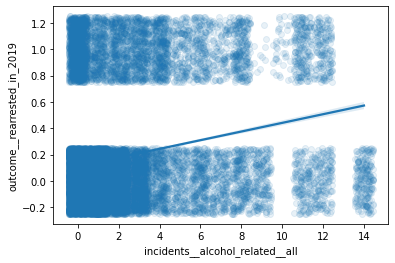

In [47]:
# Using sns.regplot to see how well the relationship with features and outcome
# For the incidents alcohol related feature, there appears to be a positive relationship between number of
# incidents and outcome to be rearrested
sns.regplot(data=Xy, x="incidents__alcohol_related__all",y='outcome__rearrested_in_2019',
          x_jitter=.45, y_jitter=.25, scatter_kws={'alpha':0.1},)

<AxesSubplot:xlabel='incidents__alcohol_related__all', ylabel='outcome__rearrested_in_2019'>

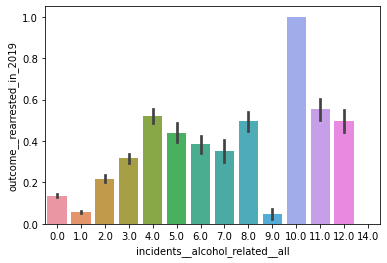

In [48]:
# This can also be seen in a bar plot where there's a slight positive correlation
sns.barplot(data=Xy, x="incidents__alcohol_related__all",y='outcome__rearrested_in_2019')

<AxesSubplot:xlabel='Severity__F', ylabel='outcome__rearrested_in_2019'>

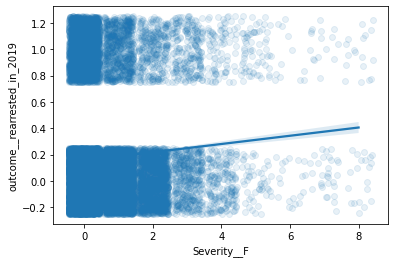

In [138]:
# For the incidents severity felony, there appears to be a positive relationship between number of
# incidents and outcome to be rearrested though less pronounced than the alcohol features
sns.regplot(data=Xy, x="Severity__F",y='outcome__rearrested_in_2019',
          x_jitter=.45, y_jitter=.25, scatter_kws={'alpha':0.1},)

<AxesSubplot:xlabel='Severity__F', ylabel='outcome__rearrested_in_2019'>

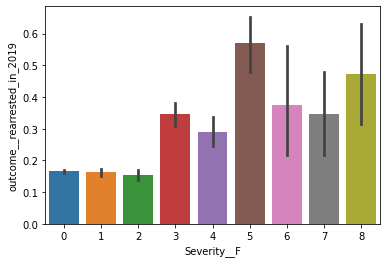

In [139]:
sns.barplot(data=Xy, x="Severity__F",y='outcome__rearrested_in_2019')

## Build models (5 points)
We are going to build two models. 

1) 
The first one will NOT include any of the features that you built. 

These are the set of features to include in the first model.
```
feature_names = ['charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White']
```


2) The second model WILL include the features you built (and include the features from 1))


Using the algorithm of your choice (e.g. decision trees, logistic regression, random forest, etc), train a model to predict `outcome__rearrested_in_2019` for both 1) and 2). 

Note:
 - For full credit you **MUST** perform hyperparameter tuning. See Lab 9 for guidance here.  
 - Make sure you have created a holdout/test set before training the models.
 - Make sure to show the selected hyperparameters after tuning for both models.

Generate predictions for your test/holdout set. 

The predictions from 1) should be in a column called `predictions_standard`

The predictions from 2) should be in a column called `predictions_augmented`


In [62]:
# Creating feature names array and outcome for model 1, splittig into train and test, size=.3

feature_names_1 = ['charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White']

outcome_1 = 'outcome__rearrested_in_2019'

X_train, X_test, y_train, y_test = train_test_split(Xy[feature_names_1], Xy[outcome_1], test_size=.3)

In [63]:
# filling in the null values of the train and test data

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [71]:
# Running a random forest classifier model
# tuning parameters incude max depth, max features, and n estimators
# Fitting the model and showing best parameters

rf_model_1 = RF_clf()

param_grid_1 = {'max_depth' : [1, 5, 10, 20],
                'max_features' : [1, 2, 3, 4],
                'n_estimators' : [100,200,500]}

model_1 = GridSearchCV(estimator=rf_model_1, param_grid=param_grid_1, cv=5, scoring='average_precision')

model_1.fit(X_train[feature_names_1], y_train)

model_1.best_params_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 5, 10, 20],
                         'max_features': [1, 2, 3, 4],
                         'n_estimators': [100, 200, 500]},
             scoring='average_precision')

{'max_depth': 20, 'max_features': 1, 'n_estimators': 500}

In [72]:
# Results from the first dataset
test_results_1 = pd.DataFrame({'outcome__rearrested_in_2019' : y_test,
                             'predictions_standard' : model_1.predict_proba(X_test)[:, 1]})
test_results_1


,outcome__rearrested_in_2019,predictions_standard
9570,0,0.116503
10191,0,0.117341
18500,0,0.117341
5312,1,1.000000
17690,0,0.411400
...,...,...
3060,0,0.411400
23298,1,0.230099
17287,0,0.116503
8853,0,0.194358


In [140]:
# Creating feature names array and outcome for model 2, splittig into train and test, size=.3

feature_names_2 = [
       'charges__NIBRS_Group_A__2016', 'charges__NIBRS_Group_A__2017',
       'charges__NIBRS_Group_A__2018', 'charges__NIBRS_Group_B__2016',
       'charges__NIBRS_Group_B__2017', 'charges__NIBRS_Group_B__2018',
       'charges__NIBRS_Group_C__2016', 'charges__NIBRS_Group_C__2017',
       'charges__NIBRS_Group_C__2018', 'arrests__race__Black',
       'arrests__race__Hispanic', 'arrests__race__Other',
       'arrests__race__White', 'incidents__alcohol_related__all',
       'incidents__drug_related__all', 'first_arr_age__18-26',
       'first_arr_age__27-35', 'first_arr_age__36-44', 'first_arr_age__45-54',
       'first_arr_age__54-62', 'first_arr_age__63-71', 'first_arr_age__72-80',
       'first_arr_age__81-89', 'first_arr_age__90-99', 'Severity__F',
       'Severity__M', 'Severity__N']

outcome_2 = 'outcome__rearrested_in_2019'

X_train, X_test, y_train, y_test = train_test_split(Xy[feature_names_2], Xy[outcome_2], test_size=.3)

In [141]:
# filling in the null values of the train and test data

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [176]:
# Running a random forest classifier model
# tuning parameters incude max depth, max features, and n estimators
# Fitting the model and showing best parameters

rf_model_2 = RF_clf()

param_grid_2 = {'max_depth' : [1, 3, 5, 8],
                'max_features' : [1, 2, 3, 4, 5],
                'n_estimators' : [200]}

model_2 = GridSearchCV(estimator=rf_model_2, param_grid=param_grid_2, cv=5, scoring='average_precision')

model_2.fit(X_train[feature_names_2], y_train)

model_2.best_params_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 8],
                         'max_features': [1, 2, 3, 4, 5],
                         'n_estimators': [200]},
             scoring='average_precision')

{'max_depth': 8, 'max_features': 5, 'n_estimators': 200}

In [177]:
# Results from the second dataset
test_results_2 = pd.DataFrame({'outcome__rearrested_in_2019' : y_test,
                             'predictions_augmented' : model_2.predict_proba(X_test)[:, 1]})
test_results_2

,outcome__rearrested_in_2019,predictions_augmented
17382,0,0.270452
7099,0,0.037391
5126,0,0.094115
17928,0,0.053577
20543,0,0.073596
...,...,...
22248,0,0.085435
24359,1,0.713650
4602,0,0.221163
1898,0,0.043406


##  Model performance (4.5 total points)
We are now going to compute precision, recall, and AUC for **both** sets of predictions.

1) Compute precision and recall using the appropriate threshold for the summer jobs program. (0.5 points)



2) Compute precision and recall using the appropriate threshold for the custom notification program. (0.5 points)



3) Compute AUC (0.5 points)



4) Based on your results here, are your features improving performance? And where in the distribution is performance being improved? Justify your answer using the results from 1), 2) , and 3) and the meaning of the performance metrics (3 points)

In [178]:
# Setting the thresholds for the two programs
notification_thresh = 1000
summer_job_thresh = 500

In [179]:
# Sorting the two test results
test_results_1 = test_results_1.sort_values('predictions_standard', ascending=False)
test_results_2 = test_results_2.sort_values('predictions_augmented', ascending=False)

In [180]:
# Setting yhat thresholds for the first model
test_results_1['yhat_not'] = 0
test_results_1.yhat_not[:notification_thresh] = 1
test_results_1['yhat_sum'] = 0
test_results_1.yhat_sum[:summer_job_thresh] = 1

# Thresholds for the second model
test_results_2['yhat_not'] = 0
test_results_2.yhat_not[:notification_thresh] = 1
test_results_2['yhat_sum'] = 0
test_results_2.yhat_sum[:summer_job_thresh] = 1

C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [181]:
# model 1 notification 
cm_model_1_not = pd.crosstab(test_results_1.yhat_not, test_results_1.outcome__rearrested_in_2019)
print("Model 1 Notification System")
cm_model_1_not
# model 1 summer program
cm_model_1_sum = pd.crosstab(test_results_1.yhat_sum, test_results_1.outcome__rearrested_in_2019)
print("Model 1 Summer Jobs Program")
cm_model_1_sum
# model 2 notification
cm_model_2_not = pd.crosstab(test_results_2.yhat_not, test_results_2.outcome__rearrested_in_2019)
print("Model 2 Notification System")
cm_model_2_not
# model 2 summer program
cm_model_2_sum = pd.crosstab(test_results_2.yhat_sum, test_results_2.outcome__rearrested_in_2019)
print("Model 2 Summer Program")
cm_model_2_sum

Model 1 Notification System


outcome__rearrested_in_2019,0,1
yhat_not,,
0,5825,635
1,360,640


Model 1 Summer Jobs Program


outcome__rearrested_in_2019,0,1
yhat_sum,,
0,6132,828
1,53,447


Model 2 Notification System


outcome__rearrested_in_2019,0,1
yhat_not,,
0,6080,380
1,70,930


Model 2 Summer Program


outcome__rearrested_in_2019,0,1
yhat_sum,,
0,6150,810
1,0,500


In [182]:
# model 1 notification metrics
print("Model 1 Notification System Performance Metrics")
ppv = cm_model_1_not.iloc[1,1] / cm_model_1_not.iloc[1, :].sum()
print('precision:', ppv)

tnr = cm_model_1_not.iloc[1, 1] / cm_model_1_not.iloc[:, 1].sum()
print('recall:', tnr)

print('AUC:', auc(test_results_1.outcome__rearrested_in_2019, test_results_1.predictions_standard))

Model 1 Notification System Performance Metrics
precision: 0.64
recall: 0.5019607843137255
AUC: 0.8375276681408215


In [183]:
# model 2 notification metrics
print("Model 2 Notification System Performance Metrics")
ppv = cm_model_2_not.iloc[1,1] / cm_model_2_not.iloc[1, :].sum()
print('precision:', ppv)

tnr = cm_model_2_not.iloc[1, 1] / cm_model_2_not.iloc[:, 1].sum()
print('recall:', tnr)

print('AUC:', auc(test_results_2.outcome__rearrested_in_2019, test_results_2.predictions_augmented))

Model 2 Notification System Performance Metrics
precision: 0.93
recall: 0.7099236641221374
AUC: 0.9554244398932539


In [184]:
# model 1 summer job program metrics
print("Model 1 Summer Job Program Performance Metrics")
ppv = cm_model_1_sum.iloc[1,1] / cm_model_1_sum.iloc[1, :].sum()
print('precision:', ppv)

tnr = cm_model_1_sum.iloc[1, 1] / cm_model_1_sum.iloc[:, 1].sum()
print('recall:', tnr)

print('AUC:', auc(test_results_1.outcome__rearrested_in_2019, test_results_1.predictions_standard))

Model 1 Summer Job Program Performance Metrics
precision: 0.894
recall: 0.35058823529411764
AUC: 0.8375276681408215


In [185]:
# model 2 summer job program metrics
print("Model 2 Notification System Performance Metrics")
ppv = cm_model_2_sum.iloc[1,1] / cm_model_2_sum.iloc[1, :].sum()
print('precision:', ppv)

tnr = cm_model_2_sum.iloc[1, 1] / cm_model_2_sum.iloc[:, 1].sum()
print('recall:', tnr)

print('AUC:', auc(test_results_2.outcome__rearrested_in_2019, test_results_2.predictions_augmented))

Model 2 Notification System Performance Metrics
precision: 1.0
recall: 0.3816793893129771
AUC: 0.9554244398932539


#### Based on the performance metrics, the augmented model has much better precision in both the notification and summer job program - meaning that a higher proportion of positive identifications were correct. The recall is also much higher for the second model in the notification system and only slightly higher in the summer job program - meaning in both cases, the augmented model correctly identified a higher proprotion of actual positive outcomes.

#### In both models, the area under the curve is fairly high. The second model is higher, showing a higher probability to rank a random positive outcome higher than a negative one - i.e. it distinguishes better between positive and negative classes.

# Part 2
Now we are going to decide whether to select the custom notification or summer jobs program.

We are only going to use `prediction_standard` or `prediction_augmented` in this section, so also first decide which one you would prefer to use.

The same algorithm will be used for both programs, all that will be different is which threshold will be used (500 for summer jobs, 1000 for custom notifications).

## Total Impact (3 total points, 1 EC point)
We first want to know what the potential for total impact is. 

- So compute: (1 point)
  - the number of arrests in 2019.
  - the number of arrests that would be accounted for by the top 500 in predicted risk. 
  - the number of arrests that would be accounted for by the top 1,000 in predicted risk. 


- Custom notifications **reduce the chance of re-arrest by 50%** (meaning that the number of arrests accounted for by the top 1,000 would be cut in half). Compute what percentage of 2019 arrests would be eliminated if the custom notification program targeted the top 1,000 and reduced re-arrest by 50%. (2 points) *(Hint: First use the fact that the number re-arrests in the top 1,000 would be cut in half, then divide that number by the total number of 2019 arrests.)*



- Summer jobs reduce the chance of re-arrest by 100% (meaning the number arrests accounted for by the top 500 would go down to zero. Compute what percentage of 2019 arrests would be eliminated if the summer jobs program targeted the top 500 and reduced re-arrest by 100%. (1 points)


**Extra Credit**: (2 points)
Jurisdictions typically care about reducing felonies much more than reducing misdemeanors. 

Compute the number of felony arrests that would be prevented by summer jobs
Compute the number of felony arrests that would be prevented by custom notifications





In [186]:
# Sum the number of rearrested in 2019 to find the number of arrests.
tot_rearrest = test_results_2.outcome__rearrested_in_2019.sum()
tot_rearrest

1310

In [187]:
# Sum predictions_augmented for first 500
tot_summer = test_results_2.predictions_augmented.iloc[:500].sum()
tot_summer

400.25944460234797

In [188]:
# Sum preditions_augmented for first 1000
tot_notif = test_results_2.predictions_augmented.iloc[:1000].sum()
tot_notif

640.752297854804

In [189]:
# Compute percentage of 2019 arrests eliminated by custom notification system
print("Percentage of rearrestes eliminated by Custom Notifications:")
(tot_notif/2)/tot_rearrest

# Compute percentage of 2019 rearrests eliminated by Summer Jobs Program
print("Percentage of rearrests eliminated by Summer Jobs Program")
tot_summer/tot_rearrest

Percentage of rearrestes eliminated by Custom Notifications:


0.24456194574610843

Percentage of rearrests eliminated by Summer Jobs Program


0.3055415607651511

In [214]:
##-----------------------------------------------------------------------------
# Extra Credit
# Create a new test results df with the severity_f felonies added
test_results_w_felonies = pd.DataFrame({'outcome__rearrested_in_2019' : y_test, 
                             'Severity_F' : X_test['Severity__F'],
                             'prediction' : model_2.predict_proba(X_test)[:, 1]})
test_results_w_felonies

,outcome__rearrested_in_2019,Severity_F,prediction
17382,0,0,0.270452
7099,0,0,0.037391
5126,0,0,0.094115
17928,0,1,0.053577
20543,0,1,0.073596
...,...,...,...
22248,0,1,0.085435
24359,1,1,0.713650
4602,0,0,0.221163
1898,0,1,0.043406


In [216]:
# Filter test results to only have the results with felonies associated with them
test_results_w_felonies = test_results_w_felonies[test_results_w_felonies.Severity_F == 1]

In [218]:
# total the number of rearrests with felonies
tot_rearrest_felonies = test_results_w_felonies.outcome__rearrested_in_2019.sum()
tot_rearrest_felonies

268

In [220]:
# Total number of rearrests using the custom notifications
tot_notif_felonies = test_results_w_felonies.prediction.iloc[:1000].sum()
tot_notif_felonies

149.33498808107646

In [221]:
# Total number of rearrests using the summer job program
tot_summer_felonies = test_results_w_felonies.prediction.iloc[:500].sum()
tot_summer_felonies

76.1251088242983

In [224]:
# Compute percentage of 2019 felony arrests eliminated by custom notification system
print("Percentage of felony rearrestes eliminated by Custom Notifications:")
(tot_notif_felonies/2)/tot_rearrest_felonies

# Compute percentage of 2019 felony rearrests eliminated by Summer Jobs Program
print("Percentage of felony rearrests eliminated by Summer Jobs Program")
tot_summer_felonies/tot_rearrest_felonies

Percentage of felony rearrestes eliminated by Custom Notifications:


0.27861005239006803

Percentage of felony rearrests eliminated by Summer Jobs Program


0.2840489135235011

## Calculating Cost (3 total points)
- Let's assume that it costs the city \$1,000 for each person enrolled in the custom notification program. First calculate the total cost of the program. Then divide this number by the total number of re-arrests prevented from part 3.1. This figure is the **cost per re-arrest prevented** (2 points)


- Let's assume that it costs the city \$5,000 for each person enrolled in the summer jobs program program. First calculate the total cost of the program. Then divide this number by the total number re-arrests prevented from part 3.1.  (1 point)





In [190]:
# Total cost for each program
notif_cost = 1000 * 1000
summ_cost = 500 * 5000

# cost per re-arrest prevented notif
print("Cost per re-arrest prevented Custom Notifications:")
notif_cost/(tot_notif/2)

# cost per re-arrest prevented summer
print("Cost per re-arrest prevented Summer Jobs:")
summ_cost/tot_summer

Cost per re-arrest prevented Custom Notifications:


3121.3309834328593

Cost per re-arrest prevented Summer Jobs:


6245.948805739523

## Fairness (3 total points)
As a mayoral candidate, you campaigned on injecting more fairness into the criminal justice process, so you would like this program to be as fair as possible. 

You care about two things:
1) If a program is going to potentially limit people's civil liberties, you want the False Positive Rates across groups to be as close to each other as possible. 


2) If a program involves the offer of a service (and is not punitive), you want the group with the highest base rate to also have the highest precision. (The mayor's reasoning here is that the groups most likely to be re-arrested are also among the most disadvantaged socio-economically, therefore, it is the mayor's belief that scarce resources should be allocated to the True Positives of those groups first.)

### FPR balance (See Lab 9 for creating confusion matrices by subgroup)
- Compute the false positive rate for for Black individuals in the top 1000 (0.5 points)


- Compute the false positive rate for for Hispanic individuals in the top 1000 (0.5 points)


- Compute the false positive rate for for White individuals in the top 1000 (0.5 points)



### Precision 

- Compute the precision for White individuals in the top 500 (0.5 points)


- Compute the precision for Black individuals in the top 500 (0.5 points)


- Compute the precision for White individuals in the top 500 (0.5 points)



In [191]:
# Creating a df with predicted results along with the race features
test_results_w_race = pd.DataFrame({'outcome__rearrested_in_2019' : y_test, 
                             'race__Black' : X_test['arrests__race__Black'],
                             'race__White' : X_test['arrests__race__Hispanic'],
                             'race__Hispanic' : X_test['arrests__race__White'],
                             'prediction' : model_2.predict_proba(X_test)[:, 1]})
test_results_w_race.head()

,outcome__rearrested_in_2019,race__Black,race__White,race__Hispanic,prediction
17382,0,0,0,1,0.270452
7099,0,0,0,1,0.037391
5126,0,1,0,0,0.094115
17928,0,1,0,0,0.053577
20543,0,1,0,0,0.073596


In [192]:
# Setting up the yhat for the first 1000 predictions sorted
test_results_w_race = test_results_w_race.sort_values('prediction', ascending=False)

test_results_w_race['yhat_1'] = 0
test_results_w_race.yhat_1[:1000] = 1

C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [193]:
# Crosstab with the race features

confusion_matrix_Black = pd.crosstab(test_results_w_race[test_results_w_race.race__Black==1].yhat_1, 
                                     test_results_w_race[test_results_w_race.race__Black==1].outcome__rearrested_in_2019)
confusion_matrix_Hispanic = pd.crosstab(test_results_w_race[test_results_w_race.race__Hispanic==1].yhat_1, 
                                     test_results_w_race[test_results_w_race.race__Hispanic==1].outcome__rearrested_in_2019)
confusion_matrix_White = pd.crosstab(test_results_w_race[test_results_w_race.race__White==1].yhat_1, 
                                     test_results_w_race[test_results_w_race.race__White==1].outcome__rearrested_in_2019)

In [194]:
#fpr
print('FPR, Black:', confusion_matrix_Black.iloc[1, 0] / confusion_matrix_Black.iloc[:, 0].sum())
print('FPR, Hispanic:', confusion_matrix_White.iloc[1, 0] / confusion_matrix_White.iloc[:, 0].sum())
print('FPR, White:', confusion_matrix_Hispanic.iloc[1, 0] / confusion_matrix_Hispanic.iloc[:, 0].sum())

FPR, Black: 0.009900990099009901
FPR, Hispanic: 0.008695652173913044
FPR, White: 0.019261637239165328


In [195]:
# Same as above except for the first 500

test_results_w_race['yhat_2'] = 0
test_results_w_race.yhat_2[:500] = 1

C:\Users\Smoo9\AppData\Local\Continuum\anaconda3\envs\inst_414_f2021\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [196]:
# Same confusion matrix with yhat 2

confusion_matrix_Black = pd.crosstab(test_results_w_race[test_results_w_race.race__Black==1].yhat_2, 
                                     test_results_w_race[test_results_w_race.race__Black==1].outcome__rearrested_in_2019)
confusion_matrix_Hispanic = pd.crosstab(test_results_w_race[test_results_w_race.race__Hispanic==1].yhat_2, 
                                     test_results_w_race[test_results_w_race.race__Hispanic==1].outcome__rearrested_in_2019)
confusion_matrix_White = pd.crosstab(test_results_w_race[test_results_w_race.race__White==1].yhat_2, 
                                     test_results_w_race[test_results_w_race.race__White==1].outcome__rearrested_in_2019)

In [197]:
# So I'm assuming at this point most all the metrics point to overfitting, but I really don't know where I went wrong.

print('PPV, Black:', confusion_matrix_Black.iloc[1, 1] / confusion_matrix_Black.iloc[1, :].sum())
print('PPV, Hispanic:', confusion_matrix_White.iloc[1, 1] / confusion_matrix_White.iloc[1, :].sum())
print('PPV, White:', confusion_matrix_Hispanic.iloc[1, 1] / confusion_matrix_Hispanic.iloc[1, :].sum())

PPV, Black: 1.0
PPV, Hispanic: 1.0
PPV, White: 1.0


# Part 3: Putting It All Together (4
total points; 1 EC point)

Now you have to make a choice. 
Decide whether you will use the algorithm to target the custom notification program or the summer jobs program.

You should mention the following dimensions when you describe your reason for choosing one program over the other:
- Predictive performance
- Potential for impact
- Cost Effectiveness
- Fairness considerations

You must cite numbers from your analysis above to receive full credit.

**Extra credit** (2 points)
If you did the extra credit in 3.1, would the impact on felony arrests change your answer above, why or why not?

#### Based on the analysis of the model, I decided to go with the algorithm for the custom notification program.
## Performance Metrics:
Both the notification program and summer jobs program have the same high AUC - 0.9554; indicating that the model does a good job of distinguishing the difference between positive and negative classes. In fact, it's nearly 1 indicating a near perfectly calibrated model. They both have high precision (0.93 for the notification system and 1.0 for the summer jobs program) indicating that a high proportion of positive indentifications were correct. The big difference is in the recall ( 0.7099 for the notification system and 0.3817 for the summer job program) where the notification system identified a higher proportion of actual positive outcomes.

## Potential for Impact:
Based on the percentage of rearrests eliminated for each program, they came out fairly similarly with the summer program being better: 0.2446 for the notification system and 0.3055 for the summer jobs program. The Summer jobs program was slightly more than 6.0% better at eliminating rearrests.

## Cost Effectiveness:
Cost effectiveness accounts for the biggest difference between the two programs. The cost per re-arrest prevented for the notification system came out to be \\$3121.33 per arrest prevented and the summer jobs program was \\$6245.95, making the summer program twice as expensive per arrest prevented

## Fairness Considerations:
The false positive rate for each of the featured races were as follows: 
    Black:     0.0099
    Hispanic:  0.0087
    White:     0.0193
I would consider these all very similar as they are less than a percentage point apart. However from a relative standpoint, white arrestees were incorrectly considered positive at twice the rate as black and hispanic arrestees.
The precision for all three were the same.
    Black:     1.0
    Hispanic:  1.0
    White:     1.0
The model seems to be over fitting because I find it unlikely that all three would have perfect precision. But I've adujusted the hyper parameters a number of times to no effect. 

It's likely I did something wrong in the process, but based on the analysis the custom notification system would come out on top as being much cheaper and accurate than the summer job program.

## Extra Credit
The impact on felony arrests would not change my choice as the two systems were evenly comparable (0.2786 for the custom notification system and 0.2840 for the summer job program. This is less than a 1% difference and not very impactful.